# Part B.

### Importing packages

In [1]:
import pandas as pd
import numpy as np
import json 
import heapq
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from tqdm import tqdm
tqdm.pandas()

/Users/nandinibasu/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Dumping json file into dataframe

In [2]:
reviews = []
for line in open('reviews_Health_and_Personal_Care_5.json', 'r'):
    reviews.append(json.loads(line))

In [3]:
reviews_df = pd.DataFrame(reviews)

In [4]:
reviews_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5.0,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4.0,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4.0,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love the Great point light pocket magnifier! ...,4.0,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This is very nice. You pull out on the magnifi...,5.0,Very nice and convenient.,1313452800,"08 16, 2011"


In [5]:
review_data = reviews_df[["reviewerID","reviewText","overall"]]

In [6]:
review_data.head()

,reviewerID,reviewText,overall
0,ALC5GH8CAMAI7,This is a great little gadget to have around. ...,5.0
1,AHKSURW85PJUE,I would recommend this for a travel magnifier ...,4.0
2,A38RMU1Y5TDP9,What I liked was the quality of the lens and t...,4.0
3,A1XZUG7DFXXOS4,Love the Great point light pocket magnifier! ...,4.0
4,A1MS3M7M7AM13X,This is very nice. You pull out on the magnifi...,5.0


### Quick data check

In [7]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346355 entries, 0 to 346354
Data columns (total 3 columns):
reviewerID    346355 non-null object
reviewText    346355 non-null object
overall       346355 non-null float64
dtypes: float64(1), object(2)
memory usage: 7.9+ MB


## Text preprocessing

In [8]:
#lower case
review_data["reviewText"]=review_data["reviewText"].str.lower() 

#tokenization words
review_data['reviewText'] = review_data.progress_apply(lambda row: word_tokenize(row['reviewText']), axis=1) 

#handling negation
review_data["reviewText"] = review_data["reviewText"].progress_apply(lambda x: ['not' if a =="n't" else a for a in x])

#removing stop words
stop = stopwords.words('english')
review_data['reviewText'] = review_data['reviewText'].progress_apply(lambda x: [a for a in x if a not in stop])

#removing punctuation and symbols
review_data["reviewText"] = review_data['reviewText'].progress_apply(lambda x: [a for a in x if a.isalpha()]) 

#stemming words
ps = PorterStemmer()
review_data['reviewText'] = review_data['reviewText'].progress_apply(lambda x : [ps.stem(a) for a in x])

#joining words back
review_data["reviewText"] = review_data["reviewText"].progress_apply(lambda x: str(' '.join(x))) 

/Users/nandinibasu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 346355/346355 [04:25<00:00, 1306.64it/s]
/Users/nandinibasu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
100%|██████████| 346355/346355 [00:04<00:00, 82169.12it/s] 
/Users/nandinibasu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is tryin

In [9]:
review_data.head()

,reviewerID,reviewText,overall
0,ALC5GH8CAMAI7,great littl gadget around alreadi use look spl...,5.0
1,AHKSURW85PJUE,would recommend travel magnifi occasion read a...,4.0
2,A38RMU1Y5TDP9,like qualiti len built light len discern disto...,4.0
3,A1XZUG7DFXXOS4,love great point light pocket magnifi work gre...,4.0
4,A1MS3M7M7AM13X,nice pull magnifi want light come slide back w...,5.0


### Mapping ratings to sentiments
A rating of 4 or 5 signifies positive sentiment 1
<br>A rating of 1 or 2 signifies negative sentiment 0

In [10]:
sentiment = {1: 0, 2: 0, 4: 1, 5: 1}
review_data["sentiment"] = review_data["overall"].map(sentiment)

/Users/nandinibasu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Data balance

In [11]:
len(review_data[review_data["sentiment"]==0]),len(review_data[review_data["sentiment"]==1])

(33300, 279801)

In [12]:
# data is severely unbalanced
review_data.head()

,reviewerID,reviewText,overall,sentiment
0,ALC5GH8CAMAI7,great littl gadget around alreadi use look spl...,5.0,1.0
1,AHKSURW85PJUE,would recommend travel magnifi occasion read a...,4.0,1.0
2,A38RMU1Y5TDP9,like qualiti len built light len discern disto...,4.0,1.0
3,A1XZUG7DFXXOS4,love great point light pocket magnifi work gre...,4.0,1.0
4,A1MS3M7M7AM13X,nice pull magnifi want light come slide back w...,5.0,1.0


### Creating balanced sample 

In [13]:
review_positive = review_data[review_data['sentiment']==1]
review_negative = review_data[review_data['sentiment']==0]

In [14]:
new_reviews = pd.concat([review_positive.sample(n=10000, random_state=1), review_negative.sample(n=10000, random_state=1)])

In [15]:
new_reviews.head()

,reviewerID,reviewText,overall,sentiment
148308,A2MU3FLFSWW4TD,use pay twice much network market scheme man i...,5.0,1.0
14870,A2WL9KZ9JXRTHQ,make great product yogurt quit tasti clean fre...,5.0,1.0
315518,A27GPXG538KWHU,use anoth major brand omega capsul decid tri d...,5.0,1.0
196317,A4E9H23O2Q9SR,like thing pretti comfort definit add support ...,4.0,1.0
269638,A27Q1X75QCWTID,usual use mach kind razor excit tri girli razo...,4.0,1.0


In [16]:
len(new_reviews[new_reviews["sentiment"]==0]),len(new_reviews[new_reviews["sentiment"]==1])

(10000, 10000)

## Text vectoization

### Bag of words

In [17]:
#Creating table of 500 most common words
word_freq = {}
for review in new_reviews['reviewText']:
    for word in review.split(' '):
        if word not in word_freq.keys():
            word_freq[word] = 1
        else:
            word_freq[word] += 1
word_freq

{'use': 15313,
 'pay': 532,
 'twice': 463,
 'much': 4069,
 'network': 7,
 'market': 436,
 'scheme': 13,
 'man': 176,
 'ignor': 42,
 'better': 3424,
 'half': 641,
 'recommend': 3134,
 'everyon': 357,
 'make': 3805,
 'great': 4090,
 'product': 11307,
 'yogurt': 76,
 'quit': 1045,
 'tasti': 106,
 'clean': 2818,
 'fresh': 489,
 'like': 8799,
 'stuff': 1384,
 'get': 7493,
 'last': 2050,
 'easi': 1771,
 'highli': 685,
 'anoth': 1412,
 'major': 225,
 'brand': 2148,
 'omega': 203,
 'capsul': 884,
 'decid': 848,
 'tri': 6202,
 'dr': 97,
 'tobia': 3,
 'say': 2703,
 'although': 510,
 'unnam': 1,
 'premium': 64,
 'claim': 516,
 'fishi': 124,
 'odor': 378,
 'smell': 2438,
 'could': 2809,
 'still': 2227,
 'bit': 1485,
 'tast': 2915,
 'everi': 1533,
 'thing': 2785,
 'pretti': 1190,
 'comfort': 817,
 'definit': 941,
 'add': 603,
 'support': 655,
 'keep': 2084,
 'wear': 819,
 'let': 801,
 'bend': 110,
 'wrist': 240,
 'uncomfort': 311,
 'spot': 344,
 'sleep': 1103,
 'dont': 217,
 'whenev': 83,
 'phone':

In [18]:
word_vector = heapq.nlargest(500, word_freq, key=word_freq.get)
word_vector

['use',
 'product',
 'like',
 'one',
 'work',
 'get',
 'would',
 'tri',
 'take',
 'good',
 'time',
 'day',
 'well',
 'realli',
 'great',
 'much',
 'make',
 'also',
 'even',
 'feel',
 'go',
 'better',
 'need',
 'help',
 'recommend',
 'buy',
 'review',
 'tast',
 'first',
 'clean',
 'shave',
 'could',
 'thing',
 'look',
 'year',
 'back',
 'say',
 'want',
 'littl',
 'seem',
 'differ',
 'price',
 'give',
 'smell',
 'two',
 'think',
 'way',
 'know',
 'still',
 'water',
 'brand',
 'see',
 'bought',
 'keep',
 'last',
 'razor',
 'got',
 'effect',
 'purchas',
 'love',
 'put',
 'find',
 'come',
 'week',
 'lot',
 'month',
 'found',
 'sinc',
 'bottl',
 'problem',
 'long',
 'read',
 'made',
 'skin',
 'start',
 'batteri',
 'someth',
 'easi',
 'supplement',
 'never',
 'oil',
 'hair',
 'sure',
 'notic',
 'mani',
 'pain',
 'pill',
 'amazon',
 'enough',
 'order',
 'nice',
 'brush',
 'money',
 'without',
 'ca',
 'may',
 'best',
 'everi',
 'less',
 'vitamin',
 'small',
 'actual',
 'bit',
 'bad',
 'peopl',


In [19]:
def word_vectors(review):
    review_vec = []
    for word in word_vector:
        if word in review.split(' '):
            review_vec.append(1)
        else:
            review_vec.append(0)
    return review_vec

In [20]:
new_reviews["bagofwords"] = new_reviews["reviewText"].progress_apply(word_vectors)

100%|██████████| 20000/20000 [00:25<00:00, 777.41it/s]


In [21]:
new_reviews.head()

,reviewerID,reviewText,overall,sentiment,bagofwords
148308,A2MU3FLFSWW4TD,use pay twice much network market scheme man i...,5.0,1.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14870,A2WL9KZ9JXRTHQ,make great product yogurt quit tasti clean fre...,5.0,1.0,"[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
315518,A27GPXG538KWHU,use anoth major brand omega capsul decid tri d...,5.0,1.0,"[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
196317,A4E9H23O2Q9SR,like thing pretti comfort definit add support ...,4.0,1.0,"[1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, ..."
269638,A27Q1X75QCWTID,usual use mach kind razor excit tri girli razo...,4.0,1.0,"[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ..."


In [22]:
bagofwords = pd.DataFrame(new_reviews["bagofwords"].values.tolist(),columns = word_vector,index = new_reviews["reviewerID"])

In [23]:
bagofwords.head()

,use,product,like,one,work,get,would,tri,take,good,...,basic,name,serv,huge,ask,monitor,immedi,smaller,arriv,avail
reviewerID,,,,,,,,,,,,,,,,,,,,,
A2MU3FLFSWW4TD,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2WL9KZ9JXRTHQ,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A27GPXG538KWHU,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A4E9H23O2Q9SR,1,0,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
A27Q1X75QCWTID,1,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF

In [24]:
vectorizer_tfidf = TfidfVectorizer(max_df=0.9)
tfidf = vectorizer_tfidf.fit_transform(new_reviews["reviewText"])

In [25]:
tfidf

<20000x20720 sparse matrix of type '<class 'numpy.float64'>'
	with 717936 stored elements in Compressed Sparse Row format>

### N-Grams

In [26]:
vectorizer_ngram = TfidfVectorizer(analyzer='word', ngram_range=(2,2), max_df=0.9)
ngram = vectorizer_ngram.fit_transform(new_reviews['reviewText'])

In [27]:
ngram

<20000x474071 sparse matrix of type '<class 'numpy.float64'>'
	with 866263 stored elements in Compressed Sparse Row format>

## Classicifation modeling

### Logistic Regression

In [28]:
def logistic(data):
    x_train, x_test, y_train, y_test = train_test_split(data, 
                                                        new_reviews["sentiment"], 
                                                        test_size=0.3, random_state=9)
    logreg = LogisticRegression(random_state=1)
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_test)
    
    confusion = print(confusion_matrix(y_test, y_pred))
    report = print(classification_report(y_test, y_pred))
    
    logreg_auc_roc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % logreg_auc_roc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    
    return confusion, report, plt.show()

### Bag of Words

[[2378  665]
 [ 639 2318]]
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78      3043
         1.0       0.78      0.78      0.78      2957

    accuracy                           0.78      6000
   macro avg       0.78      0.78      0.78      6000
weighted avg       0.78      0.78      0.78      6000



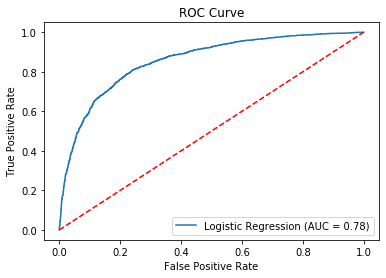

(None, None, None)

In [29]:
logistic(bagofwords)

### TFIDF

[[2513  530]
 [ 573 2384]]
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82      3043
         1.0       0.82      0.81      0.81      2957

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



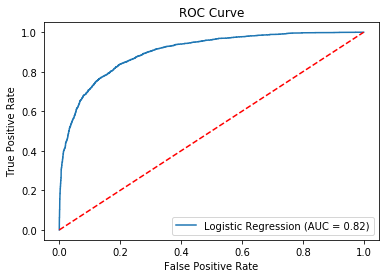

(None, None, None)

In [30]:
logistic(tfidf)

### N-Grams

[[2441  602]
 [ 700 2257]]
              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79      3043
         1.0       0.79      0.76      0.78      2957

    accuracy                           0.78      6000
   macro avg       0.78      0.78      0.78      6000
weighted avg       0.78      0.78      0.78      6000



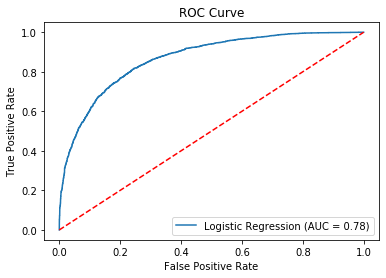

(None, None, None)

In [31]:
logistic(ngram)

### Logistic Regression using Grid Search

In [32]:
def logisticCV(data, hyperparameters):
    x_train, x_test, y_train, y_test = train_test_split(data, 
                                                        new_reviews["sentiment"], 
                                                        test_size=0.3, random_state=9)
    
    logreg = GridSearchCV(LogisticRegression(), hyperparameters, cv=2, refit=True)
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_test)
    
    confusion = print(confusion_matrix(y_test, y_pred))
    report = print(classification_report(y_test, y_pred))
    bestparams = logreg.best_params_
    
    logreg_auc_roc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % logreg_auc_roc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    
    return bestparams, confusion, report, plt.show()

In [33]:
hyperparas = {'C': np.logspace(-2, 4, 10)}

### Bag of words

[[2367  676]
 [ 634 2323]]
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78      3043
         1.0       0.77      0.79      0.78      2957

    accuracy                           0.78      6000
   macro avg       0.78      0.78      0.78      6000
weighted avg       0.78      0.78      0.78      6000



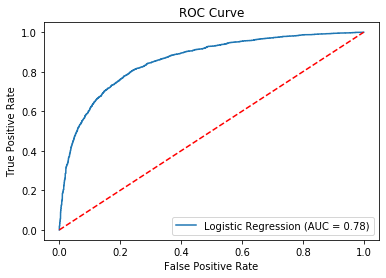

({'C': 0.046415888336127774}, None, None, None)

In [34]:
logisticCV(bagofwords, hyperparas)

### TF-IDF

/Users/nandinibasu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/nandinibasu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

[[2513  530]
 [ 573 2384]]
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82      3043
         1.0       0.82      0.81      0.81      2957

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



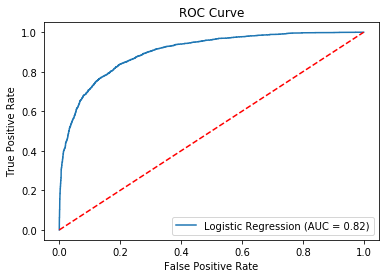

({'C': 1.0}, None, None, None)

In [35]:
logisticCV(tfidf, hyperparas)

### N-Grams

/Users/nandinibasu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/nandinibasu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

[[2482  561]
 [ 697 2260]]
              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80      3043
         1.0       0.80      0.76      0.78      2957

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.79      0.79      0.79      6000



/Users/nandinibasu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


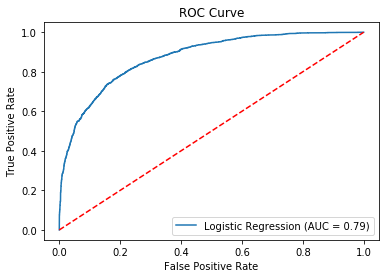

({'C': 100.0}, None, None, None)

In [36]:
logisticCV(ngram, hyperparas)

### Random Forest Classifier

In [37]:
def rfc(data):
    x_train, x_test, y_train, y_test = train_test_split(data, 
                                                        new_reviews["sentiment"], 
                                                        test_size=0.3, random_state=9)
    rfc=RandomForestClassifier(random_state=42)
    rfc.fit(x_train, y_train)
    y_pred = rfc.predict(x_test)
    
    confusion = print(confusion_matrix(y_test, y_pred))
    report = print(classification_report(y_test, y_pred))
    
    rfc_auc_roc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='RFC (AUC = %0.2f)' % rfc_auc_roc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    
    return confusion, report, plt.show()

### Bag or words

[[2383  660]
 [ 733 2224]]
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77      3043
         1.0       0.77      0.75      0.76      2957

    accuracy                           0.77      6000
   macro avg       0.77      0.77      0.77      6000
weighted avg       0.77      0.77      0.77      6000



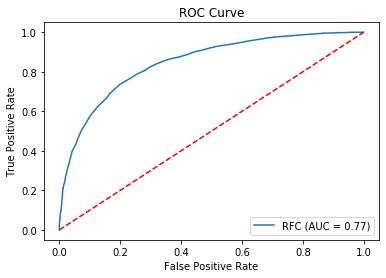

(None, None, None)

In [38]:
rfc(bagofwords)

### TF-IDF

[[2524  519]
 [ 670 2287]]
              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81      3043
         1.0       0.82      0.77      0.79      2957

    accuracy                           0.80      6000
   macro avg       0.80      0.80      0.80      6000
weighted avg       0.80      0.80      0.80      6000



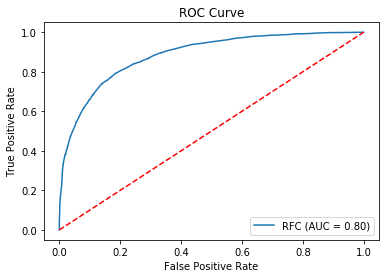

(None, None, None)

In [39]:
rfc(tfidf)

### N-grams

[[2609  434]
 [1118 1839]]
              precision    recall  f1-score   support

         0.0       0.70      0.86      0.77      3043
         1.0       0.81      0.62      0.70      2957

    accuracy                           0.74      6000
   macro avg       0.75      0.74      0.74      6000
weighted avg       0.75      0.74      0.74      6000



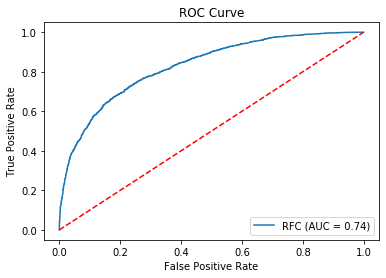

(None, None, None)

In [40]:
rfc(ngram)

### Random forest classifier with grid search

In [41]:
param_grid = {
    'bootstrap': [True],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [100, 200, 300]
}

In [42]:
def rfcCV(data, param):
    x_train, x_test, y_train, y_test = train_test_split(data, 
                                                        new_reviews["sentiment"], 
                                                        test_size=0.3, random_state=9)
    rfc_cv = GridSearchCV(RandomForestClassifier(), param, cv= 2, refit=True)
    rfc_cv.fit(x_train, y_train)
    y_pred = rfc_cv.predict(x_test)
    
    confusion = print(confusion_matrix(y_test, y_pred))
    report = print(classification_report(y_test, y_pred))
    bestparams = rfc_cv.best_params_
    
    rfc_cv_auc_roc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, rfc_cv.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='RFC CV (AUC = %0.2f)' % rfc_cv_auc_roc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    
    return bestparams, confusion, report, plt.show()

### Bag of words

[[2409  634]
 [ 698 2259]]
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78      3043
         1.0       0.78      0.76      0.77      2957

    accuracy                           0.78      6000
   macro avg       0.78      0.78      0.78      6000
weighted avg       0.78      0.78      0.78      6000



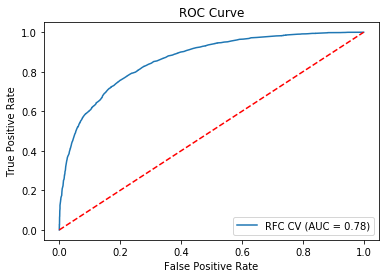

({'bootstrap': True, 'max_features': 'log2', 'n_estimators': 300},
 None,
 None,
 None)

In [43]:
rfcCV(bagofwords, param_grid)

### TD-IDF

[[2518  525]
 [ 654 2303]]
              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81      3043
         1.0       0.81      0.78      0.80      2957

    accuracy                           0.80      6000
   macro avg       0.80      0.80      0.80      6000
weighted avg       0.80      0.80      0.80      6000



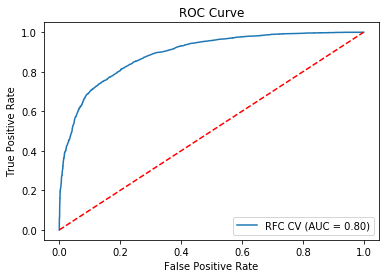

({'bootstrap': True, 'max_features': 'auto', 'n_estimators': 300},
 None,
 None,
 None)

In [44]:
rfcCV(tfidf, param_grid)

### N-grams

[[2598  445]
 [1125 1832]]
              precision    recall  f1-score   support

         0.0       0.70      0.85      0.77      3043
         1.0       0.80      0.62      0.70      2957

    accuracy                           0.74      6000
   macro avg       0.75      0.74      0.73      6000
weighted avg       0.75      0.74      0.73      6000



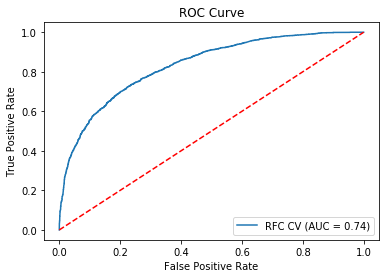

({'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200},
 None,
 None,
 None)

In [45]:
rfcCV(ngram, param_grid)

### Support Vector Machines

In [46]:
def svc(data):
    x_train, x_test, y_train, y_test = train_test_split(data, 
                                                        new_reviews["sentiment"], 
                                                        test_size=0.3, random_state=9)
    svc = SVC(probability=True)
    svc.fit(x_train, y_train)
    y_pred = svc.predict(x_test)
    
    confusion = print(confusion_matrix(y_test, y_pred))
    report = print(classification_report(y_test, y_pred))
    
    svm_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, svc.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % svm_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    
    return confusion, report, plt.show()

### Bag of words

[[2449  594]
 [ 661 2296]]
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.80      3043
         1.0       0.79      0.78      0.79      2957

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.79      0.79      0.79      6000



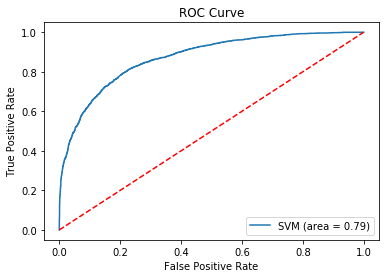

(None, None, None)

In [47]:
svc(bagofwords)

### TF-IDF

[[2530  513]
 [ 564 2393]]
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82      3043
         1.0       0.82      0.81      0.82      2957

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



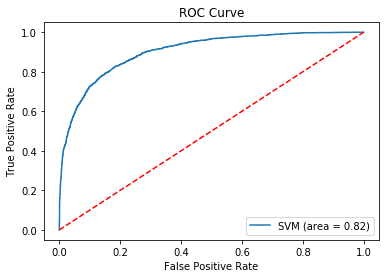

(None, None, None)

In [48]:
svc(tfidf)

### N-Grams

[[2483  560]
 [ 757 2200]]
              precision    recall  f1-score   support

         0.0       0.77      0.82      0.79      3043
         1.0       0.80      0.74      0.77      2957

    accuracy                           0.78      6000
   macro avg       0.78      0.78      0.78      6000
weighted avg       0.78      0.78      0.78      6000



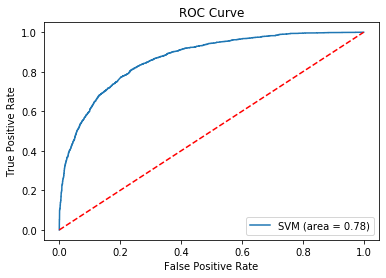

(None, None, None)

In [49]:
svc(ngram)

### Support Vector Machines with Grid Search

In [50]:
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['rbf']} 

In [51]:
def svcCV(data, param):
    x_train, x_test, y_train, y_test = train_test_split(data, 
                                                        new_reviews["sentiment"], 
                                                        test_size=0.3, random_state=9)
    
    svc_cv = GridSearchCV(SVC(probability=True), param, cv=2, refit=True)
    svc_cv.fit(x_train, y_train)
    y_pred = svc_cv.predict(x_test)
    
    confusion = print(confusion_matrix(y_test, y_pred))
    report = print(classification_report(y_test, y_pred))
    bestparams = svc_cv.best_params_
    
    svc_cv_auc_roc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, svc_cv.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='SVM CV(AUC = %0.2f)' % svc_cv_auc_roc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    
    return bestparams, confusion, report, plt.show()

### Bag of words

[[2399  644]
 [ 624 2333]]
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79      3043
         1.0       0.78      0.79      0.79      2957

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.79      0.79      0.79      6000



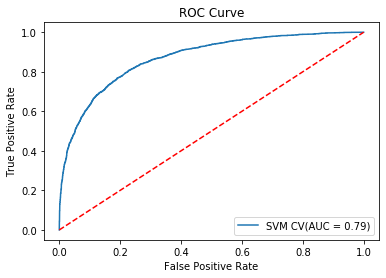

({'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}, None, None, None)

In [52]:
svcCV(bagofwords, param_grid)

### TF-IDF

[[2531  512]
 [ 565 2392]]
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82      3043
         1.0       0.82      0.81      0.82      2957

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



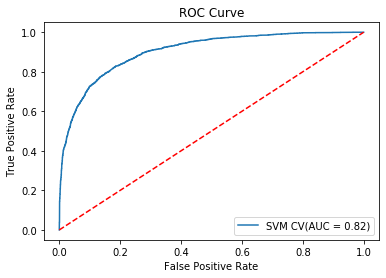

({'C': 1, 'gamma': 1, 'kernel': 'rbf'}, None, None, None)

In [53]:
svcCV(tfidf, param_grid)

### N-Grams

[[2438  605]
 [ 659 2298]]
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79      3043
         1.0       0.79      0.78      0.78      2957

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.79      0.79      0.79      6000



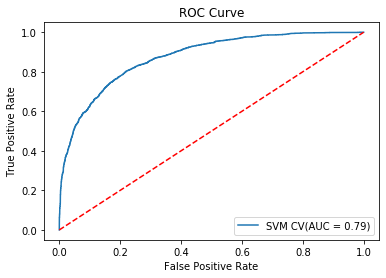

({'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, None, None, None)

In [54]:
svcCV(ngram, param_grid)